In [1]:
library(readr)
library(dplyr)
library("ROCR")

Total <- read_csv("Total_engagement_Sim_all.csv")
Expert <- read_csv("Expert.csv")

print('Total');glimpse(Total)
print('Expert');glimpse(Expert)


Warning message:
"package 'readr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ROCR' was built under R version 3.6.3"Parsed with column specification:
cols(
  .default = col_double(),
  `User Course ID` = col_character(),
  `Data Consent` = col_logical(),
  Role = col_character(),
  `Created At` = col_datetime(format = ""),
  UsedInDecision = col_logical(),
  Outcome = col_character(),
  Comment = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  Resource_ID = col_double(),
  User_ID = col_double(),
  `User Course ID` = col_character(),
  `Data Consent` = col_logical(),
  Role = col_character(),
  `Created At` = col_datetime(format = ""),
  UsedInDecision = 

[1] "Total"
Rows: 30,256
Columns: 25
$ Resource_ID        <dbl> 42586, 42591, 42592, 42595, 42596, 42597, 42599,...
$ User_ID            <dbl> 17356, 17356, 17356, 17356, 17356, 17356, 17356,...
$ `User Course ID`   <chr> "s46425058", "s46425058", "s46425058", "s4642505...
$ `Data Consent`     <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE,...
$ Role               <chr> "Moderator", "Moderator", "Moderator", "Moderato...
$ `Created At`       <dttm> 2020-08-05 19:34:00, 2020-08-05 19:47:00, 2020-...
$ UsedInDecision     <lgl> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, ...
$ Outcome            <chr> "Approved", "Denied", "Approved", "Approved", "A...
$ Content            <dbl> 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...
$ Correctness        <dbl> 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...
$ Difficulty         <dbl> 5, 4, 5, 5, 4, 4, 5, 5, 4, 4, 5, 5, 4, 3, 4, 4, ...
$ `C-Thinking`       <dbl> 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 4, 3, ...
$ Decision     

In [2]:
# library('sentimentr')
# sen<-sentiment_by(get_sentences(Total$Comment))
# Total$Sentiment<-sen$ave_sentiment
# Total$Words<-sen$word_count
# glimpse(Total)
# write.csv(Total,'Total_engagement_Sim_all.csv', row.names=FALSE)

In [3]:
(table(Expert$Decision))


 1  2  3  4  5 
30 85 89 95  4 

In [4]:
89 +95+  4
30+ 85

[1] 188

[1] 115

In [5]:
`%notin%` = Negate(`%in%`)

In [6]:
q_id=unique(Total$Resource_ID)#[1:16]
glimpse(q_id)
print('expert')
# Expert=subset(Expert,Expert$Resource_ID %in% q_id)
expert1=Expert[,c('Resource_ID','Decision')]
glimpse(expert1)

moderations=subset(Total,Resource_ID %in% q_id)[,c('Resource_ID','User_ID','Decision')]
glimpse(moderations)

u_id=unique(moderations$User_ID)
glimpse(u_id)

 num [1:2757] 42586 42591 42592 42595 42596 ...
[1] "expert"
Rows: 303
Columns: 2
$ Resource_ID <dbl> 42351, 42437, 42595, 42596, 42613, 42672, 42897, 42900,...
$ Decision    <dbl> 4, 4, 4, 4, 3, 2, 3, 2, 2, 2, 1, 2, 4, 2, 2, 2, 3, 3, 2...
Rows: 30,256
Columns: 3
$ Resource_ID <dbl> 42586, 42591, 42592, 42595, 42596, 42597, 42599, 42601,...
$ User_ID     <dbl> 17356, 17356, 17356, 17356, 17356, 17356, 17356, 17356,...
$ Decision    <dbl> 5, 5, 5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 5, 4...
 num [1:527] 17356 17358 17372 17382 17383 ...


In [7]:
################################################ Result evaluation function ################################################
results <- function(Mean_expert,Bias_Users,w=3){
# print('Cor')
x1=round(cor(Mean_expert,Bias_Users,method = "pearson"),2);
#     print(x1)

# print('RMSE')
x2=round(sqrt(mean((Mean_expert - Bias_Users)^2)),2);
#     print(x2)
Experts=ifelse(Mean_expert>=3,1,0)
Users=ifelse(Bias_Users>=w,1,0)
# print('AUC')
x3=round(as.double(performance(prediction(Users,Experts), 'auc')@y.values),2);
#     print(x3)
t=table(Users,Experts)
TN=t[1]
FP=t[2]
FN=t[3]
TP=t[4]
  
ACC=  round((TP+TN)/(TP + TN + FP + FN),2)
# print('sensitivity') ; 
    tpr=round(TP/(TP + FN),2);
#     print(tpr)
# print('specificity') ; 
    tnr=round(TN/(TN + FP),2);
#     print(tnr)

x=c(tpr,tnr,x3,ACC);
#     print(x)
write.table(t(c(x)), "clipboard", sep=" & ", row.names=FALSE, col.names=FALSE)
    return(c(x,x1,x2))
    }
################################################ reliability score function ################################################

scoreG <- function(x,a){    # reliability score function
     out <-  (2/(1+exp(-a*(x))))-1
    return(out)
    }
################################################ reward score function################################################
reward <- function(x,sigma,top){    # reward score function
     mu=0
    normal <- 1/(sqrt(2 * pi) * sigma) * exp(-((x - mu)^2/(2* sigma^2)))
    normal0 <- 1/(sqrt(2 * pi) * sigma) * exp(-(( - mu)^2/(2* sigma^2)))
    out <- top*(normal)
    return(out)
    }
################################################ punish score function################################################
punish <- function(x,sigma,top){    # punish score function
     mu=0
#     sigma= 0.5    #var(Total$Diff)/2=0.7502/2
    normal <- 1/(sqrt(2 * pi) * sigma) * exp(-((x - mu)^2/(2* sigma^2)))
    normal0 <- 1/(sqrt(2 * pi) * sigma) * exp(-(( - mu)^2/(2* sigma^2)))
    out <- top*(-normal0+normal)
    return(out)
    }
################################################ Resource Discrimination score function################################################
rdis <- function(x,eps,sigma){    # Resource Discrimination
     mu=0
    normal <- 1/(sqrt(2 * pi) * sigma) * exp(-((x - 3 - mu)^2/(2* sigma^2)))
    normal0 <- 1/(sqrt(2 * pi) * sigma) * exp(-(( - mu)^2/(2* sigma^2)))
    out <- (normal0-normal+eps)
    return(out)
    }
################################################ Trust score function ################################################

pntrust <- function(x,a){    # aprroved/reject score function
    out <-  (1/(.1+exp(-a*(x))))
   
    return(out)
    }
trust <- function(x,a){    # reliability score function
    out <-  (2/(1+exp(-a*(x))))-1
    return(out)
    }

In [8]:
library(readr)
library("ROCR")

MF_out <- read_csv("MF_out.csv")
results(MF_out$Expert,MF_out$infer,3)

Parsed with column specification:
cols(
  Resource_ID = col_double(),
  Expert = col_double(),
  infer = col_double()
)


[1] 0.55 0.68 0.62 0.60 0.34 0.99

In [9]:
inspected=vector()
k=1
for (i in Expert$Resource_ID)
    {
    if(Expert$Decision[Expert$Resource_ID==i]<3)
        {
        if (sum(Total$Decision [Total$Resource_ID==i]<3)==0)
            {
            inspected[k]=i
            k=k+1
        }
    }
}
glimpse(inspected)

 num [1:47] 42672 42928 42970 43053 43848 ...


In [10]:
Expert=subset(Expert, Resource_ID %in% Total$Resource_ID)
glimpse(Expert)

Rows: 303
Columns: 15
$ Resource_ID      <dbl> 42351, 42437, 42595, 42596, 42613, 42672, 42897, 4...
$ User_ID          <dbl> 17213, 17213, 17213, 17213, 17213, 17213, 17213, 1...
$ `User Course ID` <chr> "uqrcunni", "uqrcunni", "uqrcunni", "uqrcunni", "u...
$ `Data Consent`   <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F...
$ Role             <chr> "Moderator", "Moderator", "Moderator", "Moderator"...
$ `Created At`     <dttm> 2020-08-06 10:44:00, 2020-08-06 10:47:00, 2020-08...
$ UsedInDecision   <lgl> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TR...
$ Outcome          <chr> "Approved", "Approved", "Approved", "Approved", "A...
$ Content          <dbl> 4, 4, 4, 5, 4, 5, 4, 4, 5, 4, 3, 3, 4, 4, 4, 4, 4,...
$ Correctness      <dbl> 4, 4, 4, 4, 4, 2, 4, 2, 2, 2, 1, 2, 5, 2, 2, 2, 3,...
$ Difficulty       <dbl> 4, 5, 3, 5, 3, 4, 3, 3, 5, 3, 2, 2, 4, 3, 4, 3, 3,...
$ `C-Thinking`     <dbl> 3, 4, 3, 4, 2, 4, 3, 2, 4, 3, 2, 2, 4, 3, 4, 2, 3,...
$ Decision         <dbl> 4, 4,

In [11]:
ExpertT=subset(Expert, Resource_ID %notin% inspected)
glimpse(ExpertT)

Rows: 256
Columns: 15
$ Resource_ID      <dbl> 42351, 42437, 42595, 42596, 42613, 42897, 42900, 4...
$ User_ID          <dbl> 17213, 17213, 17213, 17213, 17213, 17213, 17213, 1...
$ `User Course ID` <chr> "uqrcunni", "uqrcunni", "uqrcunni", "uqrcunni", "u...
$ `Data Consent`   <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F...
$ Role             <chr> "Moderator", "Moderator", "Moderator", "Moderator"...
$ `Created At`     <dttm> 2020-08-06 10:44:00, 2020-08-06 10:47:00, 2020-08...
$ UsedInDecision   <lgl> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TR...
$ Outcome          <chr> "Approved", "Approved", "Approved", "Approved", "A...
$ Content          <dbl> 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4,...
$ Correctness      <dbl> 4, 4, 4, 4, 4, 4, 2, 2, 5, 2, 2, 2, 3, 3, 2, 3, 2,...
$ Difficulty       <dbl> 4, 5, 3, 5, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 4, 2, 2,...
$ `C-Thinking`     <dbl> 3, 4, 3, 4, 2, 3, 2, 3, 4, 3, 4, 2, 3, 3, 4, 2, 2,...
$ Decision         <dbl> 4, 4,

In [12]:
Test=subset(moderations,Resource_ID %in% Expert$Resource_ID)
glimpse(Test)

write.csv(Expert,'Expert_NEUR2.csv', row.names=FALSE)
write.csv(Test,'Test_NEUR2.csv', row.names=FALSE)

Rows: 3,131
Columns: 3
$ Resource_ID <dbl> 42591, 42595, 42596, 46678, 46236, 48842, 51897, 42928,...
$ User_ID     <dbl> 17356, 17356, 17356, 17356, 17358, 17358, 17358, 17372,...
$ Decision    <dbl> 5, 4, 5, 4, 4, 4, 4, 4, 5, 3, 4, 4, 4, 4, 4, 3, 4, 3, 3...


In [10]:
write.table(t(c(
length(unique(Total$Resource_ID)),
length(unique(Total$User_ID)),
dim(Total)[1]
)), "clipboard", sep="\t", row.names=FALSE, col.names=FALSE)

In [10]:
write.table(t(c(
length(unique(Expert$Resource_ID)),
length(unique(Total$User_ID[Total$Resource_ID %in% Expert$Resource_ID])),
length((Total$User_ID[Total$Resource_ID %in% Expert$Resource_ID]))
)), "clipboard", sep="\t", row.names=FALSE, col.names=FALSE)

In [11]:
write.table(t(c(
length(unique(ExpertT$Resource_ID)),
length(unique(Total$User_ID[Total$Resource_ID %in% ExpertT$Resource_ID])),
length((Total$User_ID[Total$Resource_ID %in% ExpertT$Resource_ID]))
)), "clipboard", sep="\t", row.names=FALSE, col.names=FALSE)

# Baselines

## Majority Voting

In [12]:
library('mclust')
MV_User=vector()
k=1
for (i in Expert$Resource_ID)
    {
    MV_User[k]=as.numeric(majorityVote(Total$Decision[Total$Resource_ID==i])$majority)
    k=k+1
}
results(Expert$Decision,MV_User,3)


Warning message:
"package 'mclust' was built under R version 3.6.3"Package 'mclust' version 5.4.6
Type 'citation("mclust")' for citing this R package in publications.


[1] 0.99 0.02 0.51 0.62 0.38 1.38

Warning message:
"package 'ggplot2' was built under R version 3.6.3"

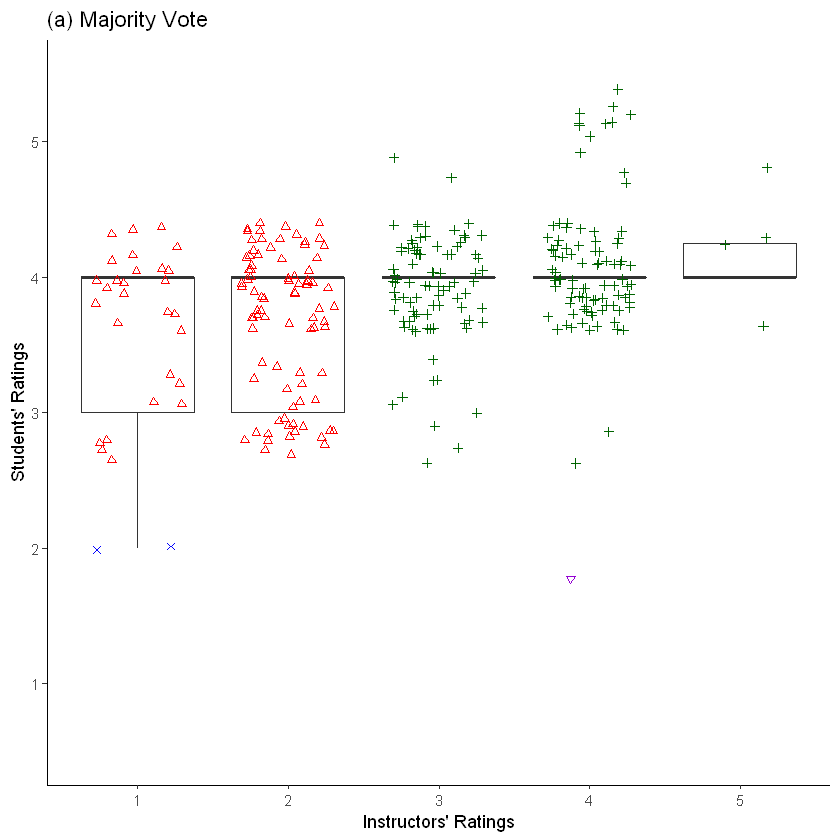

In [13]:
Decision=MV_User
expert=Expert$Decision
Test=data.frame(Decision,expert)
Test$Colour="darkgreen"
Test$Colour[Test$Decision<3]="blue"

Test$shape=3
Test$shape[Test$Decision<3]=4
Test$shape[Test$Decision<3 & Test$expert>=3]=6
Test$shape[Test$Decision>=3 & Test$expert<3]=2
Test$class="tp"
Test$class[Test$expert<3 & Test$Decision<3]="tn"

Test$Colour[Test$expert>=3 & Test$Decision<3]="darkviolet"
Test$class[Test$expert>=3 & Test$Decision<3]="fn"


Test$Colour[Test$expert<3 & Test$Decision>=3]="red"
Test$class[Test$expert<3 & Test$Decision>=3]="fp"

y_p=5.5
library(ggplot2)
box_plot2 <- ggplot(Test, aes(x=as.factor(expert), y = Decision))
bx1=box_plot2 +
    geom_boxplot(outlier.colour = "white") +
    ylim(.5,y_p)+ ylab('Students\' Ratings')+ xlab('Instructors\' Ratings')+ ggtitle('(a) Majority Vote')+
    geom_jitter(shape = Test$shape,
        color = Test$Colour,
        position = position_jitter(width = 0.31)) +
    theme_classic() 


bx1

In [14]:
library('mclust')
MV_User=vector()
k=1
for (i in ExpertT$Resource_ID)
    {
    MV_User[k]=as.numeric(majorityVote(Total$Decision[Total$Resource_ID==i])$majority)
    k=k+1
}
results(ExpertT$Decision,MV_User,3)


[1] 1.00 0.01 0.51 0.74 0.40 1.24

## Mean

In [17]:
Mean_Users=vector()
k=1
for (i in Expert$Resource_ID)
    {
    Mean_Users[k]=mean(Total$Decision[Total$Resource_ID==i])
    k=k+1
    }
results(Expert$Decision,Mean_Users,3)

[1] 1.00 0.03 0.52 0.63 0.55 1.29

In [18]:
mean=Mean_Users
expert=Expert$Decision
NEUR2=data.frame(expert,mean)



In [95]:
Mean_Users=vector()
k=1
for (i in ExpertT$Resource_ID)
    {
    Mean_Users[k]=mean(Total$Decision[Total$Resource_ID==i])
    k=k+1
    }
results(ExpertT$Decision,Mean_Users,3)

[1] 0.97 0.24 0.61 0.75 0.68 1.14

## Median

In [17]:
Mean_Users=vector()
k=1
for (i in Expert$Resource_ID)
    {
    Mean_Users[k]=median(Total$Decision[Total$Resource_ID==i])
    k=k+1
    }
results(Expert$Decision,Mean_Users,3)
Experts=ifelse(Expert$Decision>=3,1,0)
Users=ifelse(Mean_Users>=3,1,0)
print('AUC')
x3=round(as.double(performance(prediction(Users,Experts),'auc' )@y.values),2);
    print(x3)
t=table(Users,Experts);t
TN=0#t[1]
FP=t[1]
FN=0#t[3]
TP=t[2]
print('sensitivity') ; 
    tpr=round(TP/(TP + FN),2)
    print(tpr)
print('specificity') ; 
    tnr=round(TN/(TN + FP),2);
    print(tnr)

[1]   NA 0.38 0.50   NA 0.40 1.36

[1] "AUC"
[1] 0.5


     Experts
Users   0   1
    1 115 188

[1] "sensitivity"
[1] 1
[1] "specificity"
[1] 0


In [97]:
Mean_Users=vector()
k=1
for (i in ExpertT$Resource_ID)
    {
    Mean_Users[k]=median(Total$Decision[Total$Resource_ID==i])
    k=k+1
    }
results(ExpertT$Decision,Mean_Users,3)
Experts=ifelse(ExpertT$Decision>=3,1,0)
Users=ifelse(Mean_Users>=3,1,0)
print('AUC')
x3=round(as.double(performance(prediction(Users,Experts),'auc' )@y.values),2);
    print(x3)
t=table(Users,Experts);t
TN=0#t[1]
FP=t[1]
FN=0#t[3]
TP=t[2]
print('sensitivity') ; 
    tpr=round(TP/(TP + FN),2)
    print(tpr)
print('specificity') ; 
    tnr=round(TN/(TN + FP),2);
    print(tnr)

[1] 0.99 0.18 0.58 0.74 0.64 1.19

[1] "AUC"
[1] 0.58


     Experts
Users  0  1
    0  6  1
    1 27 72

[1] "sensitivity"
[1] 1
[1] "specificity"
[1] 0


## Debiased Mean

In [19]:
Bias_Users <- vector()
D=mean(Total$Decision)
k=1
for (i in Expert$Resource_ID)
    {
    b=0
        s=0
        kk=0
    for (j in Total$User_ID[Total$Resource_ID==i])
           {
          
           b= mean(Total$Decision[Total$User_ID==j])-D # Train, Total, Test
           s=s+ Total$Decision[Total$Resource_ID==i & Total$User_ID==j]-b
           kk=kk+1
               
       }
     Bias_Users[k] <- s / kk
    k= k+1
}
results(Expert$Decision,Bias_Users,3)


[1] 1.00 0.03 0.51 0.63 0.53 1.30

In [99]:
Bias_Users <- vector()
D=mean(Total$Decision)
k=1
for (i in ExpertT$Resource_ID)
    {
    b=0
        s=0
        kk=0
    for (j in Total$User_ID[Total$Resource_ID==i])
           {
          
           b= mean(Total$Decision[Total$User_ID==j])-D # Train, Total, Test
           s=s+ Total$Decision[Total$Resource_ID==i & Total$User_ID==j]-b
           kk=kk+1
               
       }
     Bias_Users[k] <- s / kk
    k= k+1
}
results(ExpertT$Decision,Bias_Users,3)


[1] 0.95 0.18 0.56 0.71 0.63 1.22

## Current Model

In [21]:
initial=1000
score <- function(x){    # reliability score function
     mu=0
    sigma= .75     #var(Total$Diff)/2=0.7502/2
    normal <- 1/(sqrt(2 * pi) * sigma) * exp(-((x - mu)^2/(2* sigma^2)))
    normal0 <- 1/(sqrt(2 * pi) * sigma) * exp(-(( - mu)^2/(2* sigma^2)))
    out <- 100*(normal-normal0/2) # 
    return(out)
    }
Total_User_ID=unique(Total$User_ID)
Total_Resource_ID=unique(Total$Resource_ID)
############## Reliabity calculation
Moderating_Score=matrix(initial, nrow = length(Total_User_ID), ncol = 1)#initial
Resource_Quality=matrix(nrow = length(Total_Resource_ID), ncol = 1)
kr=1
moderation_NEUR_current=matrix(nrow = dim(Total)[1], ncol = 3)
for(i in Total_Resource_ID)
    {

        wsum=0;
        rsum=0

            for (j in Total$User_ID[Total$Resource_ID==i] )
            {
                kk=match(j,Total_User_ID)
                if(Moderating_Score[kk]>0)
                    {
                    rsum= rsum+ (Total$Decision[Total$User_ID==j & 
                                         Total$Resource_ID==i])*
                                            Moderating_Score[kk]
                    wsum=wsum+Moderating_Score[kk]
                    }
            }
        rhat= rsum/wsum
        for (j in Total$User_ID[Total$Resource_ID==i] )
            {
                kk=match(j,Total_User_ID)
                Dr= rhat
                        ################ expert
                if(i %in% Expert$Resource_ID) {Dr=Expert$Decision[Expert$Resource_ID==i]}
                        ########################

                Moderating_Score[kk]=Moderating_Score[kk]+
                    score((Total$Decision[Total$User_ID==j & 
                                     Total$Resource_ID==i]-Dr))
             if(Moderating_Score[kk]<=0) Moderating_Score[kk]=1
      
        }
        Resource_Quality[kr]=rhat
kr=kr+1
    }
####################################
RQ=data.frame(Resource_Quality)
RQ$Resource_ID =Total_Resource_ID

############################################ Evaluation

Test_Data_Resource_ID=unique(Expert$Resource_ID)
Test_Data_Users_Decision=matrix(0, nrow = length(Test_Data_Resource_ID), ncol = 3)
k=1
for (i in Test_Data_Resource_ID)
    {
    Test_Data_Users_Decision[k,1]=i
    Test_Data_Users_Decision[k,2]=Expert$Decision[Expert$Resource_ID==i]
    Test_Data_Users_Decision[k,3]=RQ$Resource_Quality[RQ$Resource_ID==i]
   k=k+1
    }
########################################################################
Expert_Decision=Test_Data_Users_Decision[,2]
Users_Decision=Test_Data_Users_Decision[,3]
results(Expert_Decision,Users_Decision)

[1] 0.99 0.03 0.51 0.63 0.49 1.32

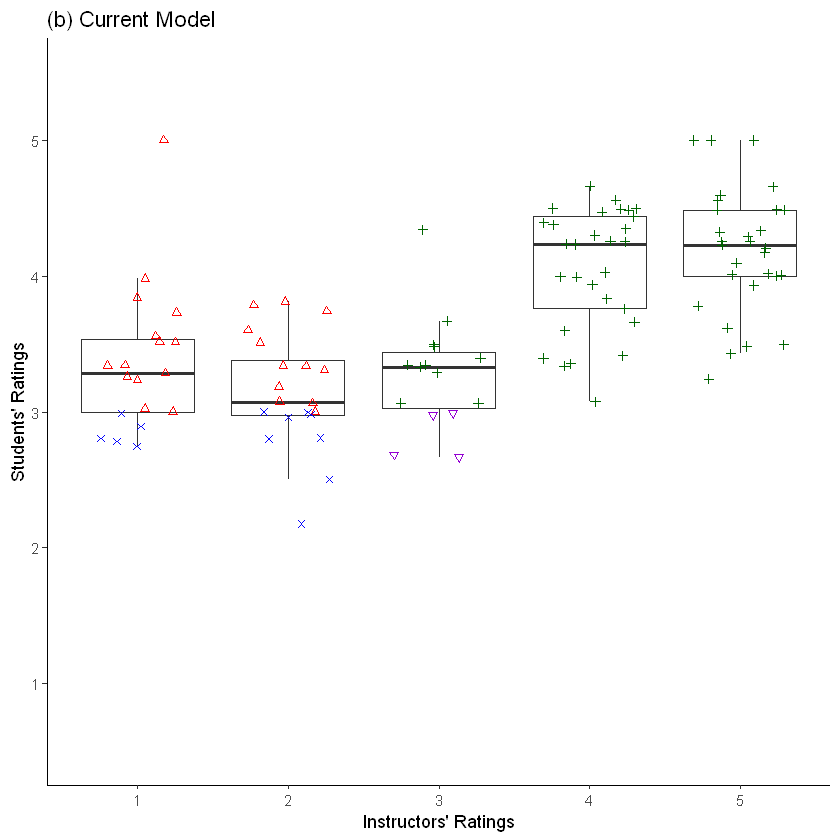

In [228]:
Decision=Users_Decision
expert=Expert_Decision
Test=data.frame(Decision,expert)
Test$Colour="darkgreen"
Test$Colour[Test$Decision<3]="blue"

Test$shape=3
Test$shape[Test$Decision<3]=4
Test$shape[Test$Decision<3 & Test$expert>=3]=6
Test$shape[Test$Decision>=3 & Test$expert<3]=2
Test$class="tp"
Test$class[Test$expert<3 & Test$Decision<3]="tn"

Test$Colour[Test$expert>=3 & Test$Decision<3]="darkviolet"
Test$class[Test$expert>=3 & Test$Decision<3]="fn"


Test$Colour[Test$expert<3 & Test$Decision>=3]="red"
Test$class[Test$expert<3 & Test$Decision>=3]="fp"

y_p=5.5
library(ggplot2)
box_plot2 <- ggplot(Test, aes(x=as.factor(expert), y = Decision))
bx2=box_plot2 +
    geom_boxplot(outlier.colour = "white") +
    ylim(.5,y_p)+ ylab('Students\' Ratings')+ xlab('Instructors\' Ratings')+ ggtitle('(b) Current Model ')+
    geom_jitter(shape = Test$shape,
        color = Test$Colour,
        position = position_jitter(width = 0.31)) +
    theme_classic() 


bx2

In [123]:
############################################ Evaluation

Test_Data_Resource_ID=unique(ExpertT$Resource_ID)
Test_Data_Users_Decision=matrix(0, nrow = length(Test_Data_Resource_ID), ncol = 3)
k=1
for (i in Test_Data_Resource_ID)
    {
    Test_Data_Users_Decision[k,1]=i
    Test_Data_Users_Decision[k,2]=ExpertT$Decision[ExpertT$Resource_ID==i]
    Test_Data_Users_Decision[k,3]=RQ$Resource_Quality[RQ$Resource_ID==i]
   k=k+1
    }
########################################################################
Expert_Decision=Test_Data_Users_Decision[,2]
Users_Decision=Test_Data_Users_Decision[,3]
results(Expert_Decision,Users_Decision)

[1] 0.95 0.39 0.67 0.77 0.68 1.15

# Graph model

In [19]:
##################################### Initializing #####################################
reward0=500 # Initial reward point
rel_teta=.001 # Relibility function coef
maxrew=100
tp=vector()
tn=vector()
auc=vector()
cor=vector()
rmse=vector()

    N=length(u_id)+1
    ##################################### Variables #####################################
    Pos=matrix(0,nrow=N ,ncol= 1 ) # Users' Positive Ratings
    Neg=matrix(0,nrow=N ,ncol= 1 ) # Users' Negative Ratings
    Rew=matrix(reward0,nrow=N ,ncol= 1 ) # Users' Rewards
    W=matrix(scoreG(reward0,rel_teta),nrow=N ,ncol= 1 ) # Users' Reliability
    W[N]=1
    Trust= diag(N) #matrix(0,nrow=N ,ncol= N ) 
    A=matrix(0,nrow=N ,ncol= N ) # agreements btw users
    D=matrix(0,nrow=N ,ncol= N ) # disagreements btw users
    WT = (Trust %*% W) # Weight based on reliability and others Trust
    RA=matrix(0,nrow=length(q_id) ,ncol= 1 ) # number of agreements on Rj
    RD=matrix(0,nrow=length(q_id) ,ncol= 1 ) # number of disagreements on Rj
    Rhat=matrix(0,nrow=length(q_id) ,ncol= 1 ) # Inferred Decision on Rj
    RhatT=matrix(0,nrow=length(q_id) ,ncol= 1 ) # Inferred Decision on Rj
    RhatN=matrix(0,nrow=length(q_id) ,ncol= 1 ) # Number of Decision on Rj
    RhatW=matrix(0,nrow=length(q_id) ,ncol= 1 ) # Number of Decision on Rj
    
    
    kq=1
    for(i in q_id)
        {
        B= Trust %*% Trust
        tau=quantile(B[1:N-1,N],names = FALSE)[1]
        tauWT=quantile(WT,names = FALSE)[1]
        tauW=quantile(W,names = FALSE)[1]
        users=moderations$User_ID[moderations$Resource_ID==i]
        n=length(users)
        si=0
        wi=0
        Win= matrix(1,nrow= n,ncol=1) # collecting user reliability
        exclude= matrix(1,nrow= N,ncol=1) # removing those moderated this resource for trust propagation and keeping others
        exclude[N]=0
        for(j in 1:(n-1))
            {
            kj=match(users[j],u_id)
            exclude[kj]=0
            Win[j]=W[kj]
            Dj=moderations$Decision[moderations$User_ID==users[j] & moderations$Resource_ID==i]
            if (W[kj]>tauW & WT[kj]>tauWT &  B[kj,N]>=tau) 
            {
#                 neg=sum(moderations$Decision[moderations$User_ID==users[j] & moderations$Resource_ID %in% q_id [1:kq]]<3)
#                 pos=sum(moderations$Decision[moderations$User_ID==users[j] & moderations$Resource_ID %in% q_id [1:kq]]>=3)
                if (Dj<3) {Neg[kj]= Neg[kj]+1; PN=(Pos[kj]+Neg[kj])/Neg[kj]}
                if (Dj>=3) {Pos[kj]= Pos[kj]+1;PN=(Pos[kj]+Neg[kj])/Pos[kj]}
                
                PNj=pntrust(PN,.5) 
                si=si+Dj*(PNj*W[kj]); wi=wi+(PNj*W[kj])
                                RhatN[kq]= RhatN[kq]+1 # number of decisions
                                RhatW[kq]= wi # number of decisions

            }                                                                               ########################## DECISION
            for(l in users[(j+1):n])
                {
                kl=match(l,u_id)
                Dl=moderations$Decision[moderations$User_ID==l & moderations$Resource_ID==i]
                if ((Dl>= 3 &  Dj>=3) | (Dl< 3 &  Dj<3)) 
                {
                    A[kj,kl]= A[kj,kl]+1;A[kl,kj]= A[kl,kj]+1;
                    RA[kq]=RA[kq]+1
                } 
                else 
                {
                    D[kj,kl]= D[kj,kl]+1;D[kl,kj]= D[kl,kj]+1;
                    RD[kq]=RD[kq]+1
                }
            }
            if (i %in% Expert$Resource_ID)
                {
                Ej=Expert$Decision[Expert$Resource_ID==i]
                if ((Ej>= 3 &  Dj>=3) )
                    {
                    A[kj,N]= A[kj,N]+1;A[N,kj]= A[N,kj]+1;
                } 
                if ( (Ej< 3 &  Dj<3))
                    {
                    A[kj,N]= A[kj,N]+1;A[N,kj]= A[N,kj]+1;
                } 
                
                if ((Ej>= 3 &  Dj<3) ) 
                    {
                    D[kj,N]= D[kj,N]+1;D[N,kj]= D[N,kj]+1;
                }
                if ((Ej< 3 &  Dj>=3) ) 
                    {
                    D[kj,N]= D[kj,N]+1;D[N,kj]= D[N,kj]+1;
                }
            }
        }
        ########################### inferred decision on R
        kj=match(users[n],u_id)
        exclude[kj]=0
        Dj=moderations$Decision[moderations$User_ID==users[n] & moderations$Resource_ID==i]
        Win[n]=W[kj]
        if (W[kj]>tauW & WT[kj]>tauWT & B[kj,N]>=tau)
            {
#                 neg=sum(moderations$Decision[moderations$User_ID==users[n] & moderations$Resource_ID %in% q_id [1:kq]]<3)
#                 pos=sum(moderations$Decision[moderations$User_ID==users[n] & moderations$Resource_ID %in% q_id [1:kq]]>=3)
                 if (Dj<3) {Neg[kj]= Neg[kj]+1; PN=(Pos[kj]+Neg[kj])/Neg[kj]}
                if (Dj>=3) {Pos[kj]= Pos[kj]+1;PN=(Pos[kj]+Neg[kj])/Pos[kj]}
                
                PNj=pntrust(PN,.5) 
                si=si+Dj*(PNj*W[kj]); wi=wi+(PNj*W[kj])
                            RhatN[kq]= RhatN[kq]+1 # number of decisions
                            RhatW[kq]= wi # weight of decisions

            }  # If Reliability User >0 AND sum trust*Relibility other users >0 ########################## DECISION
      
        Rhat[kq] = si/wi # inferred decision on R 
        RhatT[kq] = si/wi # inferred decision on R based on Users
        if(wi==0)
            {
            Rhat[kq] = 0
        RhatT[kq] = 0
        }
        Eimpact = max(Win) # no expert
        if (i %in% Expert$Resource_ID)
                {
                Ej=Expert$Decision[Expert$Resource_ID==i]
                if ((Ej>= 3 &  Dj>=3) )
                    {
                    A[kj,N]= A[kj,N]+1;A[N,kj]= A[N,kj]+1;
                } 
                if ( (Ej< 3 &  Dj<3))
                    {
                    A[kj,N]= A[kj,N]+1;A[N,kj]= A[N,kj]+1;
                } 
                
                if ((Ej>= 3 &  Dj<3) ) 
                    {
                    D[kj,N]= D[kj,N]+1;D[N,kj]= D[N,kj]+1;
                }
                if ((Ej< 3 &  Dj>=3) ) 
                    {
                    D[kj,N]= D[kj,N]+1;D[N,kj]= D[N,kj]+1;
                }
            Rhat[kq] = Ej
#             Eimpact = 1 # expert
            }
        Trust=trust((A-D),1) # Update trusts btw users
        ########################### update user reliability
        GRew=matrix(0,nrow=N ,ncol= 1 ) # Users' Gained Rewards
        TC=matrix(0,nrow=N ,ncol= 1 ) # Connected Users
        for(j in 1:n)
            {
            
            kj = match(users[j],u_id)
            TC=TC+abs(Trust[,kj])
            Dj = moderations$Decision[moderations$User_ID==users[j] & moderations$Resource_ID==i]
            Dl = Rhat[kq]
            if ((Dl>= 3 &  Dj>=3) ) 
                {
                
                point= 
                reward(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) # Gain rewards * Resoource Discrimination
                
                } 
            if ( (Dl< 3 &  Dj<3)) 
                {
                
                point= 
                 reward(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) # Gain rewards * Resoource Discrimination
                
                } 
            
            if ((Dl>= 3 &  Dj<3) ) 
                {
                point= 
                punish(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) # Recieve Punishment * Resource Discrimination
                }
            if ((Dl< 3 &  Dj>=3) ) 
                {
                point= 
                 punish(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) # Recieve Punishment * Resource Discrimination
                }
            GRew[kj] =  point
        }
        ########################### Propagation
        others=exclude*c(u_id,1) # Remove current moderators
        others[TC==0]=0 # Remove unconnected users
        for (uc in others[others!=0]) # only connected users outside the supernode
            {
            kuc=match(uc,u_id)
            relmax=W[kuc]
            Tmax=0
            for (um in users)
                {
                kum=match(um,u_id)
                if (Trust[kuc,kum]!=0)
                    {
                    if (W[kum]>relmax)
                        {
                        relmax=W[kum]
                        beta=.5
                        if (i %in% Expert$Resource_ID)
                        {
                            beta=1
                        }
                        GRew[kuc] =  GRew[kum] * Trust[kuc,kum] *beta
                        Tmax = abs(GRew[kuc])
                    }
                    if (W[kum]==relmax)
                        {
                        if (abs(GRew[kum] * Trust[kuc,kum])> Tmax)
                            {
                            relmax=W[kum]
                             beta=.5
                            if (i %in% Expert$Resource_ID)
                            {
                                beta=1
                            }
                            GRew[kuc] =  GRew[kum] * Trust[kuc,kum]* beta
                            Tmax = abs(GRew[kuc])
                        } 
                    }
                }
            }
            
            
        }
        if (i %in% Expert$Resource_ID)
            {
            others=exclude*c(u_id,1) # Remove current moderators
            GRew[N]=reward(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) 
            beta=1
            for (uc in others[others!=0]) # only connected users outside the supernode
                {
                kuc=match(uc,u_id)
                if (Trust[kuc,N]!=0)
                    {
                    GRew[kuc] =  GRew[N] * Trust[kuc,N]* beta
                    }
                
            }                  
        }

        Rew = Rew + GRew
        W = scoreG(Rew,rel_teta) # update user reliability
        W[N]=1 # Expert
        WT =  (Trust %*% W)
        kq=kq+1    
    }
    ##################################### Evaluation #####################################

RQ=data.frame(q_id,RhatT)
    inferred=vector()
    k=1
    for (i in Expert$Resource_ID)
        {
        inferred[k]=RQ$RhatT[RQ$q_id==i]
        k=k+1
    }
results(Expert$Decision,inferred,3)

[1] 0.94 0.43 0.68 0.75 0.56 1.13

In [20]:
NEUR2$graph=inferred

# Competence

In [17]:
initial=1000
score <- function(x){    # reliability score function
     mu=0
    sigma= .75     #var(Total$Diff)/2=0.7502/2
    normal <- 1/(sqrt(2 * pi) * sigma) * exp(-((x - mu)^2/(2* sigma^2)))
    normal0 <- 1/(sqrt(2 * pi) * sigma) * exp(-(( - mu)^2/(2* sigma^2)))
    out <- 100*(normal-normal0/2) # 
    return(out)
    }
Total_User_ID=unique(Total$User_ID)
Total_Resource_ID=unique(Total$Resource_ID)
############## Reliabity calculation
Moderating_Score=matrix(initial, nrow = length(Total_User_ID), ncol = 1)#initial
Resource_Quality=matrix(nrow = length(Total_Resource_ID), ncol = 1)
kr=1
moderation_NEUR_current=matrix(nrow = dim(Total)[1], ncol = 3)
for(i in Total_Resource_ID)
    {

        wsum=0;
        rsum=0

            for (j in Total$User_ID[Total$Resource_ID==i] )
            {
                kk=match(j,Total_User_ID)
                if(Moderating_Score[kk]>0)
                    {
                    rsum= rsum+ (Total$Decision[Total$User_ID==j & 
                                         Total$Resource_ID==i])*
                                            Moderating_Score[kk]*
                            (Total$correctness[Total$User_ID==j & Total$Resource_ID==i]+1)
                #engagement , correctness ,N_moderation,
                   # topic_engagement , topic_correctness , N_topic_moderation
                # "+1" is for those with 0 attempts 
                    wsum=wsum+
                    Moderating_Score[kk]*
                            (Total$correctness[Total$User_ID==j & Total$Resource_ID==i]+1)
                #engagement , correctness ,N_moderation,
                   # topic_engagement , topic_correctness , N_topic_moderation
                # "+1" is for those with 0 attempts 
                    }
            }
        rhat= rsum/wsum
        for (j in Total$User_ID[Total$Resource_ID==i] )
            {
                kk=match(j,Total_User_ID)
                Dr= rhat
                        ################ expert
                if(i %in% Expert$Resource_ID) {Dr=Expert$Decision[Expert$Resource_ID==i]}
                        ########################

                Moderating_Score[kk]=Moderating_Score[kk]+
                    score((Total$Decision[Total$User_ID==j & 
                                     Total$Resource_ID==i]-Dr))
#             if(Moderating_Score[kk]<=0) Moderating_Score[kk]=1
      
        }
        Resource_Quality[kr]=rhat
kr=kr+1
    }
####################################
RQ=data.frame(Resource_Quality)
RQ$Resource_ID =Total_Resource_ID

############################################ Evaluation

Test_Data_Resource_ID=unique(Expert$Resource_ID)
Test_Data_Users_Decision=matrix(0, nrow = length(Test_Data_Resource_ID), ncol = 3)
k=1
for (i in Test_Data_Resource_ID)
    {
    Test_Data_Users_Decision[k,1]=i
    Test_Data_Users_Decision[k,2]=Expert$Decision[Expert$Resource_ID==i]
    Test_Data_Users_Decision[k,3]=RQ$Resource_Quality[RQ$Resource_ID==i]
   k=k+1
    }
########################################################################
Expert_Decision=Test_Data_Users_Decision[,2]
Users_Decision=Test_Data_Users_Decision[,3]
results(Expert_Decision,Users_Decision)

[1] 0.99 0.10 0.54 0.65 0.38 1.33

In [18]:
NEUR2$correctness=Users_Decision

In [36]:
# User Confidence

initial=1000
score <- function(x){    # reliability score function
     mu=0
    sigma= .75     #var(Total$Diff)/2=0.7502/2
    normal <- 1/(sqrt(2 * pi) * sigma) * exp(-((x - mu)^2/(2* sigma^2)))
    normal0 <- 1/(sqrt(2 * pi) * sigma) * exp(-(( - mu)^2/(2* sigma^2)))
    out <- 100*(normal-normal0/2) # 
    return(out)
    }
Total_User_ID=unique(Total$User_ID)
Total_Resource_ID=unique(Total$Resource_ID)
############## Reliabity calculation
Moderating_Score=matrix(initial, nrow = length(Total_User_ID), ncol = 1)#initial
Resource_Quality=matrix(nrow = length(Total_Resource_ID), ncol = 1)
kr=1
moderation_NEUR_current=matrix(nrow = dim(Total)[1], ncol = 3)
for(i in Total_Resource_ID)
    {

        wsum=0;
        rsum=0

            for (j in Total$User_ID[Total$Resource_ID==i] )
            {
                kk=match(j,Total_User_ID)
                if(Moderating_Score[kk]>0)
                    {
                    rsum= rsum+ (Total$Decision[Total$User_ID==j & 
                                         Total$Resource_ID==i])*
                                            Total$Confidence[Total$User_ID==j & 
                                         Total$Resource_ID==i]
                    wsum=wsum+Total$Confidence[Total$User_ID==j & 
                                         Total$Resource_ID==i]
                    }
            }
        rhat= rsum/wsum
        for (j in Total$User_ID[Total$Resource_ID==i] )
            {
                kk=match(j,Total_User_ID)
                Dr= rhat
                        ################ expert
                if(i %in% Expert$Resource_ID) {Dr=Expert$Decision[Expert$Resource_ID==i]}
                        ########################

                Moderating_Score[kk]=Moderating_Score[kk]+
                    score((Total$Decision[Total$User_ID==j & 
                                     Total$Resource_ID==i]-Dr))
      
        }
        Resource_Quality[kr]=rhat
kr=kr+1
    }
####################################
RQ=data.frame(Resource_Quality)
RQ$Resource_ID =Total_Resource_ID

############################################ Evaluation

Test_Data_Resource_ID=unique(Expert$Resource_ID)
Test_Data_Users_Decision=matrix(0, nrow = length(Test_Data_Resource_ID), ncol = 3)
k=1
for (i in Test_Data_Resource_ID)
    {
    Test_Data_Users_Decision[k,1]=i
    Test_Data_Users_Decision[k,2]=Expert$Decision[Expert$Resource_ID==i]
    Test_Data_Users_Decision[k,3]=RQ$Resource_Quality[RQ$Resource_ID==i]
   k=k+1
    }
########################################################################
Expert_Decision=Test_Data_Users_Decision[,2]
Users_Decision=Test_Data_Users_Decision[,3]
results(Expert_Decision,Users_Decision)

[1] 1.00 0.03 0.52 0.63 0.54 1.32

# GLEU

In [22]:

Total_User_ID=unique(Total$User_ID)
Total_Resource_ID=unique(Total$Resource_ID)
############## Reliabity calculation
Resource_Quality=matrix(nrow = length(Total_Resource_ID), ncol = 1)
kr=1
for(i in Total_Resource_ID)
    {

        wsum=0;
        rsum=0

            for (j in Total$User_ID[Total$Resource_ID==i] )
            {
             
                    rsum= rsum+ (Total$Decision[Total$User_ID==j & Total$Resource_ID==i])*
                                            (1+50*Total$GLEU[Total$User_ID==j &Total$Resource_ID==i])
                    wsum=wsum+(1+50*Total$GLEU[Total$User_ID==j &Total$Resource_ID==i])
                    
            }
        rhat= rsum/wsum

        Resource_Quality[kr]=rhat
kr=kr+1
    }
####################################
RQ=data.frame(Resource_Quality)
RQ$Resource_ID =Total_Resource_ID

############################################ Evaluation

Test_Data_Resource_ID=unique(Expert$Resource_ID)
Test_Data_Users_Decision=matrix(0, nrow = length(Test_Data_Resource_ID), ncol = 3)
k=1
for (i in Test_Data_Resource_ID)
    {
    Test_Data_Users_Decision[k,1]=i
    Test_Data_Users_Decision[k,2]=Expert$Decision[Expert$Resource_ID==i]
    Test_Data_Users_Decision[k,3]=RQ$Resource_Quality[RQ$Resource_ID==i]
   k=k+1
    }
########################################################################
Expert_Decision=Test_Data_Users_Decision[,2]
Users_Decision=Test_Data_Users_Decision[,3]
results(Expert_Decision,Users_Decision)

[1] 1.00 0.10 0.55 0.66 0.51 1.26

In [21]:
results(Expert_Decision,Users_Decision)#100

[1] 0.99 0.13 0.56 0.66 0.49 1.25

# Length

In [14]:

Total_User_ID=unique(Total$User_ID)
Total_Resource_ID=unique(Total$Resource_ID)
############## Reliabity calculation
Resource_Quality=matrix(nrow = length(Total_Resource_ID), ncol = 1)
kr=1
for(i in Total_Resource_ID)
    {

        wsum=0;
        rsum=0

            for (j in Total$User_ID[Total$Resource_ID==i] )
            {
             
                    rsum= rsum+ (Total$Decision[Total$User_ID==j & Total$Resource_ID==i])*
                                            (Total$Words[Total$User_ID==j &Total$Resource_ID==i])
                    wsum=wsum+(Total$Words[Total$User_ID==j &Total$Resource_ID==i])
                    
            }
        rhat= rsum/wsum

        Resource_Quality[kr]=rhat
kr=kr+1
    }
####################################
RQ=data.frame(Resource_Quality)
RQ$Resource_ID =Total_Resource_ID

############################################ Evaluation

Test_Data_Resource_ID=unique(Expert$Resource_ID)
Test_Data_Users_Decision=matrix(0, nrow = length(Test_Data_Resource_ID), ncol = 3)
k=1
for (i in Test_Data_Resource_ID)
    {
    Test_Data_Users_Decision[k,1]=i
    Test_Data_Users_Decision[k,2]=Expert$Decision[Expert$Resource_ID==i]
    Test_Data_Users_Decision[k,3]=RQ$Resource_Quality[RQ$Resource_ID==i]
   k=k+1
    }
########################################################################
Expert_Decision=Test_Data_Users_Decision[,2]
Users_Decision=Test_Data_Users_Decision[,3]
results(Expert_Decision,Users_Decision)

[1] 0.99 0.26 0.63 0.71 0.55 1.17

In [15]:
results(Expert_Decision,Users_Decision)#100

[1] 0.99 0.26 0.63 0.71 0.55 1.17

In [19]:
NEUR2$length=Users_Decision

## Sentiment alingment

In [16]:

alingment <- function(x,y,z){   #x=Decision,y=Sentiment
th=0.398647025
if (z==0) #LINEAR
    {
         out= 
              (x-3)*(y-th)+5 #Linear
         if (x==3) {
            if (y>0) 
                out=
                    sign(th-y)*abs(y-th)+5 #Linear
             if (y<0) 
                 out=
                    sign(y+th)*abs(y+th)+5 #Linear
        }
    } 
if (z==1) #LOG
    {
         out= 
              (x-3)*sign(y-th)*log(abs(y-th)*5)+5 #log
         if (x==3) {
            if (y>0) 
                out=
             sign(th-y)*log(abs(y-th)*5)+5#log
             if (y<0) 
                 out=
             sign(y)*log(abs(y-th)*5)+5#log
        }         
     }        
    return(out)
    }
Total_User_ID=unique(Total$User_ID)
Total_Resource_ID=unique(Total$Resource_ID)
############## Reliabity calculation
Resource_Quality=matrix(nrow = length(Total_Resource_ID), ncol = 1)
kr=1
for(i in Total_Resource_ID)
    {

        wsum=0;
        rsum=0

            for (j in Total$User_ID[Total$Resource_ID==i] )
            {
             
                    rsum= rsum+ (Total$Decision[Total$User_ID==j & Total$Resource_ID==i])*
                                            alingment(Total$Decision[Total$User_ID==j & 
                                     Total$Resource_ID==i],
                                     Total$Sentiment[Total$User_ID==j & 
                                     Total$Resource_ID==i],
                                     0) # 0 for Linear and 1 for Log
                    wsum=wsum+alingment(Total$Decision[Total$User_ID==j & 
                                     Total$Resource_ID==i],
                                     Total$Sentiment[Total$User_ID==j & 
                                     Total$Resource_ID==i],
                                     0) # 0 for Linear and 1 for Log
                    
            }
        rhat= rsum/wsum

        Resource_Quality[kr]=rhat
kr=kr+1
    }
####################################
RQ=data.frame(Resource_Quality)
RQ$Resource_ID =Total_Resource_ID

############################################ Evaluation

Test_Data_Resource_ID=unique(Expert$Resource_ID)
Test_Data_Users_Decision=matrix(0, nrow = length(Test_Data_Resource_ID), ncol = 3)
k=1
for (i in Test_Data_Resource_ID)
    {
    Test_Data_Users_Decision[k,1]=i
    Test_Data_Users_Decision[k,2]=Expert$Decision[Expert$Resource_ID==i]
    Test_Data_Users_Decision[k,3]=RQ$Resource_Quality[RQ$Resource_ID==i]
   k=k+1
    }
########################################################################
Expert_Decision=Test_Data_Users_Decision[,2]
Users_Decision=Test_Data_Users_Decision[,3]
results(Expert_Decision,Users_Decision)

[1] 1.00 0.07 0.53 0.65 0.55 1.28

In [15]:
results(Expert_Decision,Users_Decision)

[1] 1.00 0.08 0.54 0.65 0.56 1.27

# BERT

In [11]:
Total_User_ID=unique(Total$User_ID)
Total_Resource_ID=unique(Total$Resource_ID)
############## Reliabity calculation
Resource_Quality=matrix(nrow = length(Total_Resource_ID), ncol = 1)
kr=1
for(i in Total_Resource_ID)
    {

        wsum=0;
        rsum=0

            for (j in Total$User_ID[Total$Resource_ID==i] )
            {
             
                    rsum= rsum+ (Total$Decision[Total$User_ID==j & Total$Resource_ID==i])*
                                            (1+100*abs(Total$similarity[Total$User_ID==j &Total$Resource_ID==i]))
                    wsum=wsum+(1+100*abs(Total$similarity[Total$User_ID==j &Total$Resource_ID==i]))
                    
            }
        rhat= rsum/wsum

        Resource_Quality[kr]=rhat
kr=kr+1
    }
####################################
RQ=data.frame(Resource_Quality)
RQ$Resource_ID =Total_Resource_ID

############################################ Evaluation

Test_Data_Resource_ID=unique(Expert$Resource_ID)
Test_Data_Users_Decision=matrix(0, nrow = length(Test_Data_Resource_ID), ncol = 3)
k=1
for (i in Test_Data_Resource_ID)
    {
    Test_Data_Users_Decision[k,1]=i
    Test_Data_Users_Decision[k,2]=Expert$Decision[Expert$Resource_ID==i]
    Test_Data_Users_Decision[k,3]=RQ$Resource_Quality[RQ$Resource_ID==i]
   k=k+1
    }
########################################################################
Expert_Decision=Test_Data_Users_Decision[,2]
Users_Decision=Test_Data_Users_Decision[,3]
results(Expert_Decision,Users_Decision)

[1] 0.99 0.22 0.60 0.70 0.57 1.21

# Length x GLEU

In [12]:
Total_User_ID=unique(Total$User_ID)
Total_Resource_ID=unique(Total$Resource_ID)
############## Reliabity calculation
Resource_Quality=matrix(nrow = length(Total_Resource_ID), ncol = 1)
kr=1
for(i in Total_Resource_ID)
    {

        wsum=0;
        rsum=0

            for (j in Total$User_ID[Total$Resource_ID==i] )
            {
             
                    rsum= rsum+ (Total$Decision[Total$User_ID==j & Total$Resource_ID==i])*
                                            (Total$Words[Total$User_ID==j &Total$Resource_ID==i])*
                                            (1+100*Total$GLEU[Total$User_ID==j &Total$Resource_ID==i])
                    wsum=wsum+(Total$Words[Total$User_ID==j &Total$Resource_ID==i])*
                                            (1+100*Total$GLEU[Total$User_ID==j &Total$Resource_ID==i])
                    
            }
        rhat= rsum/wsum

        Resource_Quality[kr]=rhat
kr=kr+1
    }
####################################
RQ=data.frame(Resource_Quality)
RQ$Resource_ID =Total_Resource_ID

############################################ Evaluation

Test_Data_Resource_ID=unique(Expert$Resource_ID)
Test_Data_Users_Decision=matrix(0, nrow = length(Test_Data_Resource_ID), ncol = 3)
k=1
for (i in Test_Data_Resource_ID)
    {
    Test_Data_Users_Decision[k,1]=i
    Test_Data_Users_Decision[k,2]=Expert$Decision[Expert$Resource_ID==i]
    Test_Data_Users_Decision[k,3]=RQ$Resource_Quality[RQ$Resource_ID==i]
   k=k+1
    }
########################################################################
Expert_Decision=Test_Data_Users_Decision[,2]
Users_Decision=Test_Data_Users_Decision[,3]
results(Expert_Decision,Users_Decision)

[1] 0.98 0.27 0.63 0.71 0.52 1.18

# Length x BERT

In [21]:
Total_User_ID=unique(Total$User_ID)
Total_Resource_ID=unique(Total$Resource_ID)
############## Reliabity calculation
Resource_Quality=matrix(nrow = length(Total_Resource_ID), ncol = 1)
kr=1
for(i in Total_Resource_ID)
    {

        wsum=0;
        rsum=0

            for (j in Total$User_ID[Total$Resource_ID==i] )
            {
             
                    rsum= rsum+ (Total$Decision[Total$User_ID==j & Total$Resource_ID==i])*
                                            (Total$Words[Total$User_ID==j &Total$Resource_ID==i])*
                                            (1+100*abs(Total$similarity[Total$User_ID==j &Total$Resource_ID==i]))
                    wsum=wsum+(Total$Words[Total$User_ID==j &Total$Resource_ID==i])*
                                            (1+100*abs(Total$similarity[Total$User_ID==j &Total$Resource_ID==i]))
                    
            }
        rhat= rsum/wsum

        Resource_Quality[kr]=rhat
kr=kr+1
    }
####################################
RQ=data.frame(Resource_Quality)
RQ$Resource_ID =Total_Resource_ID

############################################ Evaluation

Test_Data_Resource_ID=unique(Expert$Resource_ID)
Test_Data_Users_Decision=matrix(0, nrow = length(Test_Data_Resource_ID), ncol = 3)
k=1
for (i in Test_Data_Resource_ID)
    {
    Test_Data_Users_Decision[k,1]=i
    Test_Data_Users_Decision[k,2]=Expert$Decision[Expert$Resource_ID==i]
    Test_Data_Users_Decision[k,3]=RQ$Resource_Quality[RQ$Resource_ID==i]
   k=k+1
    }
########################################################################
Expert_Decision=Test_Data_Users_Decision[,2]
Users_Decision=Test_Data_Users_Decision[,3]
results(Expert_Decision,Users_Decision)

[1] 0.98 0.31 0.65 0.73 0.55 1.14

In [22]:
NEUR2$bert=Users_Decision

# Graph with Length X BERT

In [23]:
moderations=Total
##################################### Initializing #####################################
reward0=500 # Initial reward point
rel_teta=.001 # Relibility function coef
maxrew=100
tp=vector()
tn=vector()
auc=vector()
cor=vector()
rmse=vector()

    N=length(u_id)+1
    ##################################### Variables #####################################
    Pos=matrix(0,nrow=N ,ncol= 1 ) # Users' Positive Ratings
    Neg=matrix(0,nrow=N ,ncol= 1 ) # Users' Negative Ratings
    Rew=matrix(reward0,nrow=N ,ncol= 1 ) # Users' Rewards
    W=matrix(scoreG(reward0,rel_teta),nrow=N ,ncol= 1 ) # Users' Reliability
    W[N]=1
    Trust= diag(N) #matrix(0,nrow=N ,ncol= N ) 
    A=matrix(0,nrow=N ,ncol= N ) # agreements btw users
    D=matrix(0,nrow=N ,ncol= N ) # disagreements btw users
    WT = (Trust %*% W) # Weight based on reliability and others Trust
    RA=matrix(0,nrow=length(q_id) ,ncol= 1 ) # number of agreements on Rj
    RD=matrix(0,nrow=length(q_id) ,ncol= 1 ) # number of disagreements on Rj
    Rhat=matrix(0,nrow=length(q_id) ,ncol= 1 ) # Inferred Decision on Rj
    RhatT=matrix(0,nrow=length(q_id) ,ncol= 1 ) # Inferred Decision on Rj
    RhatN=matrix(0,nrow=length(q_id) ,ncol= 1 ) # Number of Decision on Rj
    RhatW=matrix(0,nrow=length(q_id) ,ncol= 1 ) # Number of Decision on Rj
    
    
    kq=1
    for(i in q_id)
        {
        B= Trust %*% Trust
        tau=quantile(B[1:N-1,N],names = FALSE)[1]
        tauWT=quantile(WT,names = FALSE)[1]
        tauW=quantile(W,names = FALSE)[1]
        users=moderations$User_ID[moderations$Resource_ID==i]
        n=length(users)
        si=0
        wi=0
        Win= matrix(1,nrow= n,ncol=1) # collecting user reliability
        exclude= matrix(1,nrow= N,ncol=1) # removing those moderated this resource for trust propagation and keeping others
        exclude[N]=0
        for(j in 1:(n-1))
            {
            kj=match(users[j],u_id)
            exclude[kj]=0
            Win[j]=W[kj]
            Dj=moderations$Decision[moderations$User_ID==users[j] & moderations$Resource_ID==i]
            if (W[kj]>tauW & WT[kj]>tauWT &  B[kj,N]>=tau) 
            {
#                 neg=sum(moderations$Decision[moderations$User_ID==users[j] & moderations$Resource_ID %in% q_id [1:kq]]<3)
#                 pos=sum(moderations$Decision[moderations$User_ID==users[j] & moderations$Resource_ID %in% q_id [1:kq]]>=3)
                if (Dj<3) {Neg[kj]= Neg[kj]+1; PN=(Pos[kj]+Neg[kj])/Neg[kj]}
                if (Dj>=3) {Pos[kj]= Pos[kj]+1;PN=(Pos[kj]+Neg[kj])/Pos[kj]}
                
                PNj=pntrust(PN,.5) 
                si=si+Dj*(PNj*W[kj])* 
                (moderations$Words[moderations$User_ID==users[j] & moderations$Resource_ID==i])*
                    (1+100*abs(moderations$similarity[moderations$User_ID==users[j] &moderations$Resource_ID==i]))
                wi=wi+(PNj*W[kj])* 
                (moderations$Words[moderations$User_ID==users[j] & moderations$Resource_ID==i])*
                    (1+100*abs(moderations$similarity[moderations$User_ID==users[j] &moderations$Resource_ID==i]))
                                RhatN[kq]= RhatN[kq]+1 # number of decisions
                                RhatW[kq]= wi # number of decisions

            }                                                                               ########################## DECISION
            for(l in users[(j+1):n])
                {
                kl=match(l,u_id)
                Dl=moderations$Decision[moderations$User_ID==l & moderations$Resource_ID==i]
                if ((Dl>= 3 &  Dj>=3) | (Dl< 3 &  Dj<3)) 
                {
                    A[kj,kl]= A[kj,kl]+1;A[kl,kj]= A[kl,kj]+1;
                    RA[kq]=RA[kq]+1
                } 
                else 
                {
                    D[kj,kl]= D[kj,kl]+1;D[kl,kj]= D[kl,kj]+1;
                    RD[kq]=RD[kq]+1
                }
            }
            if (i %in% Expert$Resource_ID)
                {
                Ej=Expert$Decision[Expert$Resource_ID==i]
                if ((Ej>= 3 &  Dj>=3) )
                    {
                    A[kj,N]= A[kj,N]+1;A[N,kj]= A[N,kj]+1;
                } 
                if ( (Ej< 3 &  Dj<3))
                    {
                    A[kj,N]= A[kj,N]+1;A[N,kj]= A[N,kj]+1;
                } 
                
                if ((Ej>= 3 &  Dj<3) ) 
                    {
                    D[kj,N]= D[kj,N]+1;D[N,kj]= D[N,kj]+1;
                }
                if ((Ej< 3 &  Dj>=3) ) 
                    {
                    D[kj,N]= D[kj,N]+1;D[N,kj]= D[N,kj]+1;
                }
            }
        }
        ########################### inferred decision on R
        kj=match(users[n],u_id)
        exclude[kj]=0
        Dj=moderations$Decision[moderations$User_ID==users[n] & moderations$Resource_ID==i]
        Win[n]=W[kj]
        if (W[kj]>tauW & WT[kj]>tauWT & B[kj,N]>=tau)
            {
#                 neg=sum(moderations$Decision[moderations$User_ID==users[n] & moderations$Resource_ID %in% q_id [1:kq]]<3)
#                 pos=sum(moderations$Decision[moderations$User_ID==users[n] & moderations$Resource_ID %in% q_id [1:kq]]>=3)
                 if (Dj<3) {Neg[kj]= Neg[kj]+1; PN=(Pos[kj]+Neg[kj])/Neg[kj]}
                if (Dj>=3) {Pos[kj]= Pos[kj]+1;PN=(Pos[kj]+Neg[kj])/Pos[kj]}
                
                PNj=pntrust(PN,.5) 
                si=si+Dj*(PNj*W[kj])* 
                (moderations$Words[moderations$User_ID==users[n] & moderations$Resource_ID==i])*
                    (1+100*abs(moderations$similarity[moderations$User_ID==users[n] & moderations$Resource_ID==i]))
                wi=wi+(PNj*W[kj])* 
                (moderations$Words[moderations$User_ID==users[n] & moderations$Resource_ID==i])*
                    (1+100*abs(moderations$similarity[moderations$User_ID==users[n] & moderations$Resource_ID==i]))
                            RhatN[kq]= RhatN[kq]+1 # number of decisions
                            RhatW[kq]= wi # weight of decisions

            }  # If Reliability User >0 AND sum trust*Relibility other users >0 ########################## DECISION
      
        Rhat[kq] = si/wi # inferred decision on R 
        RhatT[kq] = si/wi # inferred decision on R based on Users
        if(wi==0)
            {
            Rhat[kq] = 0
        RhatT[kq] = 0
        }
        Eimpact = max(Win) # no expert
        if (i %in% Expert$Resource_ID)
                {
                Ej=Expert$Decision[Expert$Resource_ID==i]
                if ((Ej>= 3 &  Dj>=3) )
                    {
                    A[kj,N]= A[kj,N]+1;A[N,kj]= A[N,kj]+1;
                } 
                if ( (Ej< 3 &  Dj<3))
                    {
                    A[kj,N]= A[kj,N]+1;A[N,kj]= A[N,kj]+1;
                } 
                
                if ((Ej>= 3 &  Dj<3) ) 
                    {
                    D[kj,N]= D[kj,N]+1;D[N,kj]= D[N,kj]+1;
                }
                if ((Ej< 3 &  Dj>=3) ) 
                    {
                    D[kj,N]= D[kj,N]+1;D[N,kj]= D[N,kj]+1;
                }
            Rhat[kq] = Ej
#             Eimpact = 1 # expert
            }
        Trust=trust((A-D),1) # Update trusts btw users
        ########################### update user reliability
        GRew=matrix(0,nrow=N ,ncol= 1 ) # Users' Gained Rewards
        TC=matrix(0,nrow=N ,ncol= 1 ) # Connected Users
        for(j in 1:n)
            {
            
            kj = match(users[j],u_id)
            TC=TC+abs(Trust[,kj])
            Dj = moderations$Decision[moderations$User_ID==users[j] & moderations$Resource_ID==i]
            Dl = Rhat[kq]
            if ((Dl>= 3 &  Dj>=3) ) 
                {
                
                point= 
                reward(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) # Gain rewards * Resoource Discrimination
                
                } 
            if ( (Dl< 3 &  Dj<3)) 
                {
                
                point= 
                 reward(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) # Gain rewards * Resoource Discrimination
                
                } 
            
            if ((Dl>= 3 &  Dj<3) ) 
                {
                point= 
                punish(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) # Recieve Punishment * Resource Discrimination
                }
            if ((Dl< 3 &  Dj>=3) ) 
                {
                point= 
                 punish(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) # Recieve Punishment * Resource Discrimination
                }
            GRew[kj] =  point
        }
        ########################### Propagation
        others=exclude*c(u_id,1) # Remove current moderators
        others[TC==0]=0 # Remove unconnected users
        for (uc in others[others!=0]) # only connected users outside the supernode
            {
            kuc=match(uc,u_id)
            relmax=W[kuc]
            Tmax=0
            for (um in users)
                {
                kum=match(um,u_id)
                if (Trust[kuc,kum]!=0)
                    {
                    if (W[kum]>relmax)
                        {
                        relmax=W[kum]
                        beta=.5
                        if (i %in% Expert$Resource_ID)
                        {
                            beta=1
                        }
                        GRew[kuc] =  GRew[kum] * Trust[kuc,kum] *beta
                        Tmax = abs(GRew[kuc])
                    }
                    if (W[kum]==relmax)
                        {
                        if (abs(GRew[kum] * Trust[kuc,kum])> Tmax)
                            {
                            relmax=W[kum]
                             beta=.5
                            if (i %in% Expert$Resource_ID)
                            {
                                beta=1
                            }
                            GRew[kuc] =  GRew[kum] * Trust[kuc,kum]* beta
                            Tmax = abs(GRew[kuc])
                        } 
                    }
                }
            }
            
            
        }
        if (i %in% Expert$Resource_ID)
            {
            others=exclude*c(u_id,1) # Remove current moderators
            GRew[N]=reward(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) 
            beta=1
            for (uc in others[others!=0]) # only connected users outside the supernode
                {
                kuc=match(uc,u_id)
                if (Trust[kuc,N]!=0)
                    {
                    GRew[kuc] =  GRew[N] * Trust[kuc,N]* beta
                    }
                
            }                  
        }

        Rew = Rew + GRew
        W = scoreG(Rew,rel_teta) # update user reliability
        W[N]=1 # Expert
        WT =  (Trust %*% W)
        kq=kq+1    
    }
    ##################################### Evaluation #####################################

RQ=data.frame(q_id,RhatT)
    inferred=vector()
    k=1
    for (i in Expert$Resource_ID)
        {
        inferred[k]=RQ$RhatT[RQ$q_id==i]
        k=k+1
    }
results(Expert$Decision,inferred,3)

[1] 0.91 0.50 0.71 0.76 0.56 1.05

In [26]:
NEUR2$Gbert=inferred

In [20]:
write.csv(NEUR2,'NEUR2_Length_outcomes.csv', row.names=FALSE)